## How does our 2D convolutional model do?

In [32]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER
from data.data import DataPreparation
import torch

In [33]:
dim = "2D"
inject_type = "feature"

In [34]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
checkpoints = AggregateCheckpoints()

In [58]:
chk = checkpoints.load_checkpoint(
    "DER",
    "linear_homoskedastic",
    inject_type,
    dim,
    "low",
    99,
    DEVICE,
    path="../DeepUQResources/checkpoints/",
    loss="DER",
    COEFF=0.01
)

DER
loading this chk ../DeepUQResources/checkpoints/DER_linear_homoskedastic_feature_2D_noise_low_loss_DER_COEFF_0.01_epoch_99.pt


In [59]:
# set up the model and then load the checkpoint
DERmodel, lossFn = model_setup_DER(
    "DER", DEVICE, n_hidden=64, data_type=dim)

In [60]:
# define the model at this epoch
DERmodel.load_state_dict(chk.get("model_state_dict"))
# checkpoint['model_state_dict'])
DERmodel.eval()


Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (2): DERLayer()
)

In [61]:
size_df = 1000
data = DataPreparation()
if dim == "0D":
    data.sample_params_from_prior(size_df)
    data.simulate_data(
        data.params,
        noise_to_sigma[noise],
        "linear_homoskedastic",
        inject_type=inject_type,
        seed=41,
    )
    df_array = data.get_dict()
    # Convert non-tensor entries to tensors
    df = {}
    for key, value in df_array.items():

        if isinstance(value, TensorDataset):
            # Keep tensors as they are
            df[key] = value
        else:
            # Convert lists to tensors
            df[key] = torch.tensor(value)
    len_df = len(df["params"][:, 0].numpy())
    len_x = np.shape(df["output"])[1]
    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))

    inputs = np.array([xs_array, ms_array, bs_array]).T
elif dim == "2D":
    data.sample_params_from_prior(
        size_df,
        low=[1, 1, -1.5],
        high=[10, 10, 1.5],
        n_params=3,
        seed=41)
    model_inputs, model_outputs = data.simulate_data_2d(
        size_df,
        data.params,
        image_size=32,
        inject_type=inject_type)

_, x_test, _, y_test = DataPreparation.train_val_split(
    model_inputs, model_outputs, val_proportion=0.1,
    random_state=41
)

In [62]:
chk.get("norm_params")

{'inputmin': -5.011306452099085,
 'inputmax': 46.58965616578873,
 'outputmin': 11.865956746958787,
 'outputmax': 6997.391380354034}

In [63]:
def normalize(inputs, outputs, normalization_params):
    inputmin = normalization_params["inputmin"]
    inputmax = normalization_params["inputmax"]
    inputs = (inputs - inputmin) / (inputmax - inputmin)
    outputmin = normalization_params["outputmin"]
    outputmax = normalization_params["outputmax"]
    outputs = (outputs - outputmin) / (outputmax - outputmin)
    return inputs, outputs

In [64]:
inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))

In [65]:
y_pred = DERmodel(
    torch.Tensor(inputs_test
        )
    ).detach().numpy()

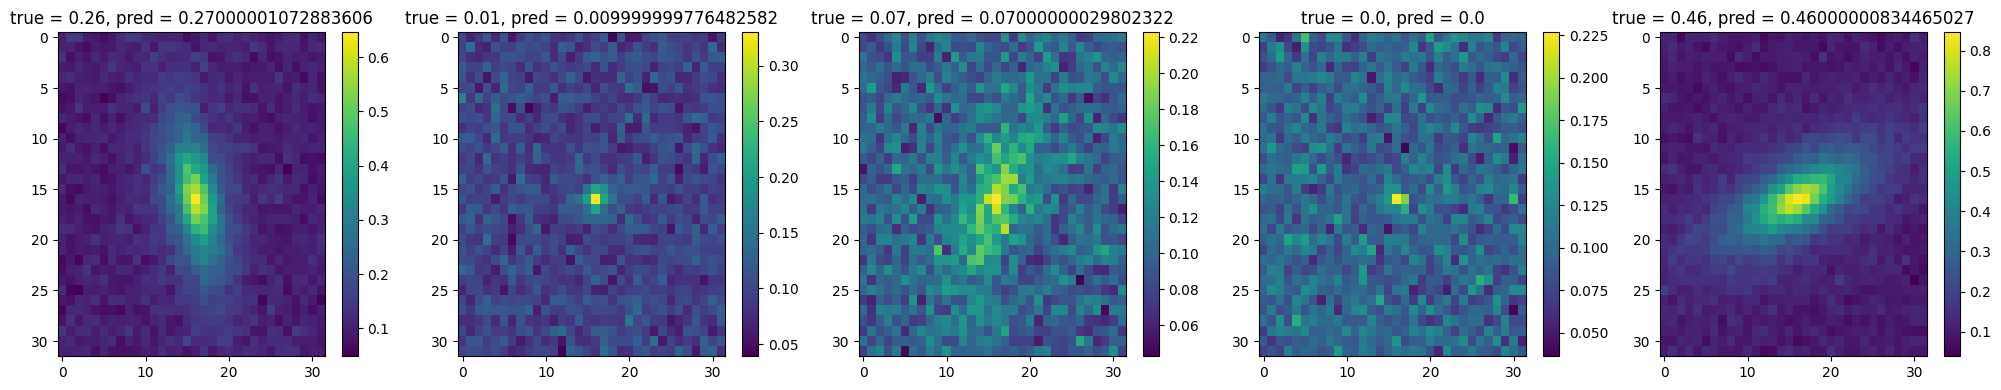

In [66]:
# Create a figure with 5 subplots in a horizontal row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figsize as needed

# Loop through each subplot
for i in range(5):
    ax = axes[i]
    ax.imshow(inputs_test[i, :, :], aspect='auto')
    ax.set_title(f'true = {round(outputs_test[i],2)}, pred = {round(y_pred[i,0],2)}')
    ax.figure.colorbar(ax.images[0], ax=ax)

# Show the complete figure
plt.tight_layout()
plt.show()

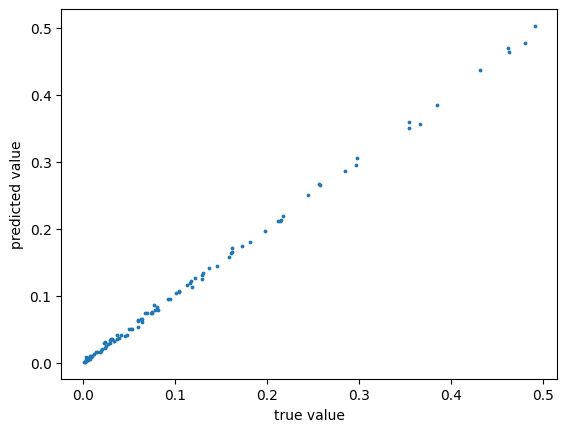

In [67]:
import matplotlib.pyplot as plt
plt.scatter(
            outputs_test,
            y_pred[:, 0],
            #color=color_list[i],
            #label=r"$\sigma = $" + str(sigma_list[i]),
            s=3,
        )
plt.xlabel('true value')
plt.ylabel('predicted value');